# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [189]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [190]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import  Normalizer
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.weight = None
        self.bias = None
        self.normalizer = None
        self.pca = None
        self.sigma = None

        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer = Normalizer()
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            self.pca = PCA(n_components =  self.new_dim)
            X = self.pca.fit_transform(X)
        num_samples = int(1e6)
        idx = np.random.choice(np.arange(X.shape[0]), size=(2, num_samples))
        idx = idx[:, idx[1] != idx[0]]
        pairwise_sq_diffs = np.sum((X[idx[0]] - X[idx[1]])**2, axis=1)
        self.sigma = np.median(pairwise_sq_diffs)
        self.weight = np.random.normal(0, 1/self.sigma, (X.shape[1], self.n_features))
        self.bias = np.random.uniform(-np.pi, np.pi, (1, self.n_features))
        
        rff = np.cos(X @ self.weight + self.bias)
        if self.classifier == 'svm':
            self.classifier = LinearSVC(max_iter=10000)
        else:
            self.classifier = LogisticRegression(max_iter=10000)
        self.classifier.fit(rff, y)
        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict_proba(rff)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict(rff)

In [92]:
from sklearn.metrics import accuracy_score

In [95]:
%%time
RFF = RFFPipeline()
RFF.fit(x_train, y_train)
y_pred = RFF.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.8801
CPU times: user 1h 39min 55s, sys: 52.8 s, total: 1h 40min 48s
Wall time: 13min 45s


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

Дальше, чтобы не ждать так долго, буду брать только подвыборку объектов

In [93]:
np.random.seed(42)
idx = np.random.choice(np.arange(x_train.shape[0]), 20000, replace=False)

### RFF svm на подмножестве признаков

In [94]:
%%time
RFF_svm = RFFPipeline(classifier='svm')
RFF_svm.fit(x_train[idx], y_train[idx])
y_pred_svm = RFF_svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.8612
CPU times: user 6min 15s, sys: 2.82 s, total: 6min 18s
Wall time: 5min 20s


### RFF logreg на подмножестве признаков

In [96]:
%%time
RFF_logreg = RFFPipeline()
RFF_logreg.fit(x_train[idx], y_train[idx])
y_pred_logreg = RFF_logreg.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.8801
CPU times: user 43min 43s, sys: 23.1 s, total: 44min 6s
Wall time: 6min 4s


### Linear svm на подмножестве признаков

In [97]:
%%time
clf_lin_svm = LinearSVC(max_iter=10000)
clf_lin_svm.fit(x_train[idx], y_train[idx])
y_pred_linear_svm = clf_lin_svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_linear_svm))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


accuracy: 0.7504
CPU times: user 5min 10s, sys: 240 ms, total: 5min 10s
Wall time: 5min 10s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Sigmoid svm на подмножетсве признаков

In [98]:
from sklearn.svm import SVC

In [99]:
%%time
clf_svm_sigm = SVC(kernel='sigmoid', max_iter=10000)
clf_svm_sigm.fit(x_train[idx], y_train[idx])
y_pred_svm_sigm = clf_svm_sigm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm_sigm))

accuracy: 0.3951
CPU times: user 2min 14s, sys: 221 ms, total: 2min 14s
Wall time: 2min 14s


### Poly svm на подмножетсве признаков

In [100]:
%%time
clf_svm_poly = SVC(kernel='poly', max_iter=10000)
clf_svm_poly.fit(x_train[idx], y_train[idx])
y_pred_svm_poly = clf_svm_poly.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm_poly))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


accuracy: 0.8389
CPU times: user 1min 15s, sys: 54.3 ms, total: 1min 15s
Wall time: 1min 16s


### rbf svm на подмножестве признаков

In [101]:
%%time
clf_svm_rbf = SVC(kernel='rbf', max_iter=10000)
clf_svm_rbf.fit(x_train[idx], y_train[idx])
y_pred_svm_rbf = clf_svm_rbf.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm_rbf))

accuracy: 0.8665
CPU times: user 1min 23s, sys: 55.9 ms, total: 1min 23s
Wall time: 1min 23s


### linear svm на подмножестве признаков

In [193]:
%%time
clf_svm_linear = SVC(kernel='linear', max_iter=10000)
clf_svm_linear.fit(x_train[idx], y_train[idx])
y_pred_svm_linear = clf_svm_linear.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm_linear))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


accuracy: 0.7639
CPU times: user 1min 3s, sys: 52.5 ms, total: 1min 3s
Wall time: 1min 3s


### LightGBM + PCA

In [102]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split

In [103]:
def objective(trial):
    param = {
        "num_trees": trial.suggest_int("num_trees", 20, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0, 1)
    }
    
    clf = lgb.LGBMClassifier(**param).fit(x_train_new, y_train_new)
    y_pred = clf.predict(x_val).reshape(1, -1)[0]
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

x_train_new, x_val, y_train_new, y_val = train_test_split(x_train_pca, y_train, test_size=0.2, random_state=42)
study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=50)

[I 2024-02-17 16:09:00,398] A new study created in memory with name: no-name-3b7134a5-2eb8-45e1-aa1a-f52949ae79c0
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=183, num_trees=183 will be ignored. Current value: num_iterations=183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:06,229] Trial 0 finished with value: 0.6126666666666667 and parameters: {'num_trees': 183, 'learning_rate': 0.765211163984848}. Best is trial 0 with value: 0.6126666666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=173, num_trees=173 will be ignored. Current value: num_iterations=173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:10,517] Trial 1 finished with value: 0.5848333333333333 and parameters: {'num_trees': 173, 'learning_rate': 0.9128598860355689}. Best is trial 0 with value: 0.6126666666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=47, num_trees=47 will be ignored. Current value: num_iterations=47
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:09:12,923] Trial 2 finished with value: 0.7719166666666667 and parameters: {'num_trees': 47, 'learning_rate': 0.5646237998925088}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=187, num_trees=187 will be ignored. Current value: num_iterations=187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:17,309] Trial 3 finished with value: 0.60475 and parameters: {'num_trees': 187, 'learning_rate': 0.9892786435911696}. Best is trial 2 with value: 0.7719166666666667.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=182, num_trees=182 will be ignored. Current value: num_iterations=182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:25,285] Trial 4 finished with value: 0.1385 and parameters: {'num_trees': 182, 'learning_rate': 0.35027519430819076}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=90, num_trees=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-02-17 16:09:29,837] Trial 5 finished with value: 0.66775 and parameters: {'num_trees': 90, 'learning_rate': 0.6596271247192657}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=122, num_trees=122 will be ignored. Current value: num_iterations=122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:33,322] Trial 6 finished with value: 0.5985 and parameters: {'num_trees': 122, 'learning_rate': 0.958628579475996}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=98, num_trees=98 will be ignored. Current value: num_iterations=98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-02-17 16:09:38,838] Trial 7 finished with value: 0.6815 and parameters: {'num_trees': 98, 'learning_rate': 0.5583524332645141}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=166, num_trees=166 will be ignored. Current value: num_iterations=166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:09:46,783] Trial 8 finished with value: 0.47825 and parameters: {'num_trees': 166, 'learning_rate': 0.46704814463817645}. Best is trial 2 with value: 0.7719166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=163, num_trees=163 will be ignored. Current value: num_iterations=163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:09:56,839] Trial 9 finished with value: 0.8685 and parameters: {'num_trees': 163, 'learning_rate': 0.03266827919692661}. Best is trial 9 with value: 0.8685.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=133, num_trees=133 will be ignored. Current value: num_iterations=133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:05,051] Trial 10 finished with value: 0.86475 and parameters: {'num_trees': 133, 'learning_rate': 0.030878774980278516}. Best is trial 9 with value: 0.8685.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=142, num_trees=142 will be ignored. Current value: num_iterations=142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:13,604] Trial 11 finished with value: 0.875 and parameters: {'num_trees': 142, 'learning_rate': 0.09517087601894697}. Best is trial 11 with value: 0.875.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=145, num_trees=145 will be ignored. Current value: num_iterations=145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:22,449] Trial 12 finished with value: 0.8661666666666666 and parameters: {'num_trees': 145, 'learning_rate': 0.03467441402592139}. Best is trial 11 with value: 0.875.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=149, num_trees=149 will be ignored. Current value: num_iterations=149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:31,353] Trial 13 finished with value: 0.8774166666666666 and parameters: {'num_trees': 149, 'learning_rate': 0.20935788860213772}. Best is trial 13 with value: 0.8774166666666666.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=79, num_trees=79 will be ignored. Current value: num_iterations=79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:36,234] Trial 14 finished with value: 0.8715833333333334 and parameters: {'num_trees': 79, 'learning_rate': 0.23389976331463191}. Best is trial 13 with value: 0.8774166666666666.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=144, num_trees=144 will be ignored. Current value: num_iterations=144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:44,855] Trial 15 finished with value: 0.8799166666666667 and parameters: {'num_trees': 144, 'learning_rate': 0.19089173749118082}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=63, num_trees=63 will be ignored. Current value: num_iterations=63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:10:48,806] Trial 16 finished with value: 0.8706666666666667 and parameters: {'num_trees': 63, 'learning_rate': 0.2119071825541382}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_trees=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:10:59,074] Trial 17 finished with value: 0.6925833333333333 and parameters: {'num_trees': 200, 'learning_rate': 0.3392701874007554}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=110, num_trees=110 will be ignored. Current value: num_iterations=110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:11:05,860] Trial 18 finished with value: 0.8774166666666666 and parameters: {'num_trees': 110, 'learning_rate': 0.1922814550117063}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=153, num_trees=153 will be ignored. Current value: num_iterations=153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:11:13,788] Trial 19 finished with value: 0.629 and parameters: {'num_trees': 153, 'learning_rate': 0.36521506024665684}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=122, num_trees=122 will be ignored. Current value: num_iterations=122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:11:21,503] Trial 20 finished with value: 0.8779166666666667 and parameters: {'num_trees': 122, 'learning_rate': 0.13314704934864047}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=119, num_trees=119 will be ignored. Current value: num_iterations=119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.

[I 2024-02-17 16:11:29,549] Trial 21 finished with value: 0.8761666666666666 and parameters: {'num_trees': 119, 'learning_rate': 0.16698252828228677}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=127, num_trees=127 will be ignored. Current value: num_iterations=127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:11:36,543] Trial 22 finished with value: 0.7663333333333333 and parameters: {'num_trees': 127, 'learning_rate': 0.2787030744713309}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=153, num_trees=153 will be ignored. Current value: num_iterations=153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:11:45,786] Trial 23 finished with value: 0.8775 and parameters: {'num_trees': 153, 'learning_rate': 0.11946124648072383}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=104, num_trees=104 will be ignored. Current value: num_iterations=104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:11:52,235] Trial 24 finished with value: 0.87375 and parameters: {'num_trees': 104, 'learning_rate': 0.11837478061945665}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=138, num_trees=138 will be ignored. Current value: num_iterations=138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:11:59,540] Trial 25 finished with value: 0.4945 and parameters: {'num_trees': 138, 'learning_rate': 0.4280609596803903}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=157, num_trees=157 will be ignored. Current value: num_iterations=157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:09,040] Trial 26 finished with value: 0.8794166666666666 and parameters: {'num_trees': 157, 'learning_rate': 0.12920496704362525}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=27, num_trees=27 will be ignored. Current value: num_iterations=27
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:10,743] Trial 27 finished with value: 0.85775 and parameters: {'num_trees': 27, 'learning_rate': 0.27566222602778245}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=112, num_trees=112 will be ignored. Current value: num_iterations=112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:17,582] Trial 28 finished with value: 0.87525 and parameters: {'num_trees': 112, 'learning_rate': 0.09217198864251377}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=80, num_trees=80 will be ignored. Current value: num_iterations=80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:21,883] Trial 29 finished with value: 0.7974166666666667 and parameters: {'num_trees': 80, 'learning_rate': 0.29737195139621153}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=163, num_trees=163 will be ignored. Current value: num_iterations=163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:12:30,529] Trial 30 finished with value: 0.6885 and parameters: {'num_trees': 163, 'learning_rate': 0.4238248234022586}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=151, num_trees=151 will be ignored. Current value: num_iterations=151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:39,734] Trial 31 finished with value: 0.8771666666666667 and parameters: {'num_trees': 151, 'learning_rate': 0.1381632412923098}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=172, num_trees=172 will be ignored. Current value: num_iterations=172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:49,800] Trial 32 finished with value: 0.8415 and parameters: {'num_trees': 172, 'learning_rate': 0.00867566515282664}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=131, num_trees=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:12:58,048] Trial 33 finished with value: 0.8766666666666667 and parameters: {'num_trees': 131, 'learning_rate': 0.08820668035252002}. Best is trial 15 with value: 0.8799166666666667.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=184, num_trees=184 will be ignored. Current value: num_iterations=184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:13:09,577] Trial 34 finished with value: 0.883 and parameters: {'num_trees': 184, 'learning_rate': 0.1479322899747151}. Best is trial 34 with value: 0.883.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=184, num_trees=184 will be ignored. Current value: num_iterations=184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:13:20,074] Trial 35 finished with value: 0.6460833333333333 and parameters: {'num_trees': 184, 'learning_rate': 0.2586906947958}. Best is trial 34 with value: 0.883.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=197, num_trees=197 will be ignored. Current value: num_iterations=197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:13:32,038] Trial 36 finished with value: 0.88125 and parameters: {'num_trees': 197, 'learning_rate': 0.17458057771530291}. Best is trial 34 with value: 0.883.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=196, num_trees=196 will be ignored. Current value: num_iterations=196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:13:36,836] Trial 37 finished with value: 0.4675 and parameters: {'num_trees': 196, 'learning_rate': 0.8279557487283312}. Best is trial 34 with value: 0.883.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2024-02-17 16:13:41,641] Trial 38 finished with value: 0.62025 and parameters: {'num_trees': 179, 'learning_rate': 0.6582665736653344}. Best is trial 34 with value: 0.883.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=191, num_trees=191 will be ignored. Current value: num_iterations=191
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:13:53,214] Trial 39 finished with value: 0.88375 and parameters: {'num_trees': 191, 'learning_rate': 0.17635690375048416}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=192, num_trees=192 will be ignored. Current value: num_iterations=192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:14:04,302] Trial 40 finished with value: 0.8796666666666667 and parameters: {'num_trees': 192, 'learning_rate': 0.32442726892896057}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=193, num_trees=193 will be ignored. Current value: num_iterations=193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:14:14,052] Trial 41 finished with value: 0.711 and parameters: {'num_trees': 193, 'learning_rate': 0.33148171552843686}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=189, num_trees=189 will be ignored. Current value: num_iterations=189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:14:25,493] Trial 42 finished with value: 0.8808333333333334 and parameters: {'num_trees': 189, 'learning_rate': 0.17665450413725065}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=177, num_trees=177 will be ignored. Current value: num_iterations=177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:14:36,517] Trial 43 finished with value: 0.8803333333333333 and parameters: {'num_trees': 177, 'learning_rate': 0.178041743307164}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=175, num_trees=175 will be ignored. Current value: num_iterations=175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:14:47,332] Trial 44 finished with value: 0.8803333333333333 and parameters: {'num_trees': 175, 'learning_rate': 0.16910260235293828}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=188, num_trees=188 will be ignored. Current value: num_iterations=188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:14:59,183] Trial 45 finished with value: 0.87775 and parameters: {'num_trees': 188, 'learning_rate': 0.07203050397262187}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=172, num_trees=172 will be ignored. Current value: num_iterations=172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:15:09,522] Trial 46 finished with value: 0.8830833333333333 and parameters: {'num_trees': 172, 'learning_rate': 0.23667732485732842}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=167, num_trees=167 will be ignored. Current value: num_iterations=167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:15:18,253] Trial 47 finished with value: 0.6878333333333333 and parameters: {'num_trees': 167, 'learning_rate': 0.38788787782211365}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_trees=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210


[I 2024-02-17 16:15:29,397] Trial 48 finished with value: 0.741 and parameters: {'num_trees': 200, 'learning_rate': 0.23136094748127167}. Best is trial 39 with value: 0.88375.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=187, num_trees=187 will be ignored. Current value: num_iterations=187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 50
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.306551
[LightGBM] [Info] Start training from score -2.303627
[LightGBM] [Info] Start training from score -2.299257
[LightGBM] [Info] Start training from score -2.303002
[LightGBM] [Info] Start training from score -2.304879
[LightGBM] [Info] Start training from score -2.306342
[LightGBM] [Info] Start training from score -2.294080
[LightGBM] [Info] Start training from score -2.301960
[LightGBM] [Info] Start training from score -2.303210
[LightGBM] [Warning] No further splits with positive gain

[I 2024-02-17 16:15:35,962] Trial 49 finished with value: 0.507 and parameters: {'num_trees': 187, 'learning_rate': 0.5924234369254735}. Best is trial 39 with value: 0.88375.


In [104]:
print('best accuracy:',study.best_trials[0].values )
print('num trees:', study.best_trials[0].params['num_trees'])
print('learning rate:', study.best_trials[0].params['learning_rate'])

best accuracy: [0.88375]
num trees: 191
learning rate: 0.17635690375048416


In [105]:
%%time
lgb_clf =lgb.LGBMClassifier(num_trees = study.best_trials[0].params['num_trees'], learning_rate = study.best_trials[0].params['learning_rate']).fit(x_train_pca, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=191, num_trees=191 will be ignored. Current value: num_iterations=191
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 50
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
CPU times: user 18.2 s, sys: 5.2 s, total: 23.4 s
Wall ti

In [106]:
y_pred_lgb = lgb_clf.predict(x_test_pca)
print('accuracy:', accuracy_score(y_test, y_pred_lgb))

accuracy: 0.7821


RFF правда хорошо работает, потому что дает качетво, сопоставимое с ядровым SVM. Но RFF работает медленнее ядрового SVM, потому что мы решаем много дополнительных задач: нормируем данные, ищем PCA и тд. Хуже всего отработал SVM с линейным и сигмоидным ядром

Бустинг дал совсем немного хуже результат и очень быстро отработал

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [191]:
%%time
RFF_lr = RFFPipeline(use_PCA = False)
RFF_lr.fit(x_train[idx], y_train[idx])
y_pred_lr = RFF_lr.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_lr))

accuracy: 0.8462
CPU times: user 34min 33s, sys: 22 s, total: 34min 55s
Wall time: 5min 3s


In [108]:
%%time
RFF_svm = RFFPipeline(use_PCA = False, classifier='svm')
RFF_svm.fit(x_train[idx], y_train[idx])
y_pred_svm = RFF_svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.8321
CPU times: user 4min 52s, sys: 5.43 s, total: 4min 57s
Wall time: 4min 54s


In [109]:
acc_for_features = []

for n_features in range(100, 1500, 150):
  RFF = RFFPipeline(n_features=n_features)
  RFF.fit(x_train[idx], y_train[idx])
  y_pred = RFF.predict(x_test)
  acc_for_features.append(accuracy_score(y_test, y_pred))
  print(f'RFF + PCA, n_features={n_features} accuracy:', acc_for_features[-1])

RFF + PCA, n_features=100 accuracy: 0.838
RFF + PCA, n_features=250 accuracy: 0.855
RFF + PCA, n_features=400 accuracy: 0.8595
RFF + PCA, n_features=550 accuracy: 0.8624
RFF + PCA, n_features=700 accuracy: 0.8646
RFF + PCA, n_features=850 accuracy: 0.8652
RFF + PCA, n_features=1000 accuracy: 0.8689
RFF + PCA, n_features=1150 accuracy: 0.867
RFF + PCA, n_features=1300 accuracy: 0.8678
RFF + PCA, n_features=1450 accuracy: 0.8686


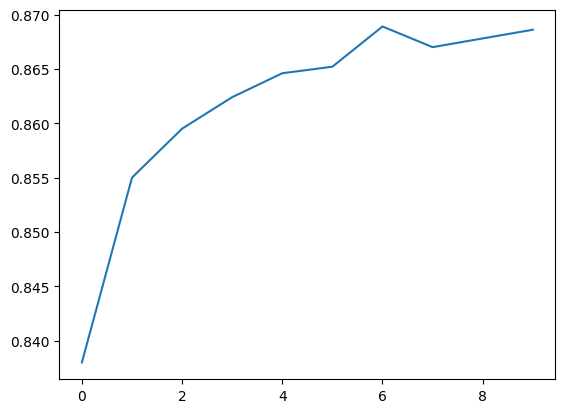

In [110]:
from matplotlib.pyplot import plot

plot(acc_for_features)

In [111]:
%%time 
RFF_lr = RFFPipeline()
RFF_lr.fit(x_train[idx], y_train[idx])
y_pred_lr = RFF_lr.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_lr))

accuracy: 0.8683
CPU times: user 33min 31s, sys: 22.5 s, total: 33min 53s
Wall time: 4min 37s


In [112]:
%%time 
RFF_svm = RFFPipeline(classifier='svm')
RFF_svm.fit(x_train[idx], y_train[idx])
y_pred_svm = RFF_svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_svm))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy: 0.8613
CPU times: user 6min 19s, sys: 989 ms, total: 6min 20s
Wall time: 5min 25s


1. Понижение размерности помогает, от этого время сокращается, а скор увеличивается

2. чем больше n_features, тем лучше, но при этом с какого-то момента качество начинает очень незначительно расти, почти плато

3. Лучше использовать логистическую регрессию, потому что времени татится меньше, а качество при этом лучше

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [186]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.weight = None
        self.bias = None
        self.normalizer = None
        self.pca = None
        self.sigma = None

    def get_weights(self, d):
        G = np.random.normal(loc=0, scale=1, size=(d, d)) 
        Q, _ = np.linalg.qr(G)
        S = np.sqrt(np.random.chisquare(d, size=d))
        return (np.diag(S) @ Q) / np.sqrt(self.sigma)

        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer = Normalizer()
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            self.pca = PCA(n_components =  self.new_dim)
            X = self.pca.fit_transform(X)

        D = self.n_features
        d = X.shape[1]
        if d > D:
            return -1
        

        num_samples =int(1e6)
        idx = np.random.choice(np.arange(X.shape[0]), size=(2, num_samples))
        idx = idx[:, idx[1] != idx[0]]
        pairwise_sq_diffs = np.sum((X[idx[0]] - X[idx[1]])**2, axis=1)
        self.sigma = np.median(pairwise_sq_diffs)


        n_stacks = int(np.ceil(D // d))

        weights = []
        for _ in range(n_stacks):
            weights.append(self.get_weights(X.shape[1]))
        self.weight = np.hstack(weights)
                
        self.bias = np.random.uniform(-np.pi, np.pi,  (1, self.n_features))

        rff = np.cos(X @ self.weight + self.bias)
        if self.classifier == 'svm':
            self.classifier = LinearSVC(max_iter=10000)
        else:
            self.classifier = LogisticRegression(max_iter=10000)
        self.classifier.fit(rff, y)
        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict_proba(rff)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict(rff)

In [187]:
%%time
ORF = ORFPipeline()
ORF.fit(x_train[idx], y_train[idx])
y_pred_orf = ORF.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_orf))

accuracy: 0.8684
CPU times: user 38min 54s, sys: 15.3 s, total: 39min 9s
Wall time: 5min 18s


In [188]:
%%time
ORF_svm = ORFPipeline(classifier='svm')
ORF_svm.fit(x_train[idx], y_train[idx])
y_pred_orf_svm = ORF_svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_orf_svm))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


accuracy: 0.8689
CPU times: user 6min 48s, sys: 2.53 s, total: 6min 50s
Wall time: 5min 52s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
acc_for_features = []

for n_features in range(100, 1500, 150):
  ORF = ORFPipeline(n_features=n_features)
  ORF.fit(x_train[idx], y_train[idx])
  y_pred = ORF.predict(x_test)
  acc_for_features.append(accuracy_score(y_test, y_pred))
  print(f'ORF + PCA, n_features={n_features} accuracy:', acc_for_features[-1])

ORF + PCA, n_features=100 accuracy: 0.8409
ORF + PCA, n_features=250 accuracy: 0.8543
ORF + PCA, n_features=400 accuracy: 0.863
ORF + PCA, n_features=550 accuracy: 0.8665
ORF + PCA, n_features=700 accuracy: 0.8694
ORF + PCA, n_features=850 accuracy: 0.8657
ORF + PCA, n_features=1000 accuracy: 0.8735
ORF + PCA, n_features=1150 accuracy: 0.8699
ORF + PCA, n_features=1300 accuracy: 0.8694
ORF + PCA, n_features=1450 accuracy: 0.873


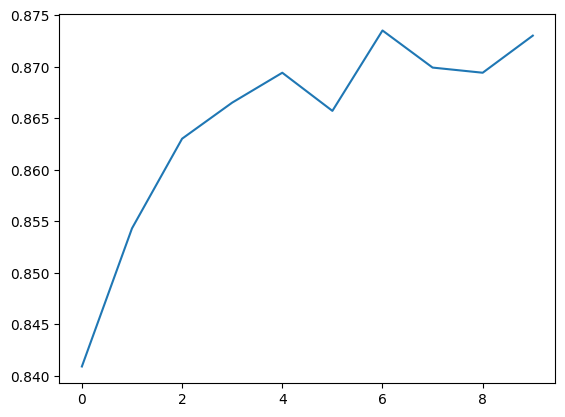

In [13]:
plot(acc_for_features)

В целом результаты такие же, как для не ортонормированных признаков. Accuracy примерно такой же и при увеличении n_features качество тоже начинает колебаться в маленьком промежутке, то есть можно сказать, что выходит на плато

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import  Normalizer
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


class RFFP_sign_pipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.weight = None
        self.bias = None
        self.normalizer = None
        self.pca = None
        self.sigma = None

        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer = Normalizer()
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            self.pca = PCA(n_components =  self.new_dim)
            X = self.pca.fit_transform(X)
        num_samples = min(int(1e6), X.shape[0])
        idx = np.random.choice(np.arange(X.shape[0]), size=(2, num_samples))
        idx = idx[:, idx[1] != idx[0]]
        pairwise_sq_diffs = np.sum((X[idx[0]] - X[idx[1]])**2, axis=1)
        self.sigma = np.median(pairwise_sq_diffs)
        self.weight = np.random.normal(0, 1/self.sigma, (X.shape[1], self.n_features))
        self.bias = np.random.uniform(-np.pi, np.pi, (1, self.n_features))
        rff = np.sign(X @ self.weight + self.bias)
        if self.classifier == 'svm':
            self.classifier = LinearSVC(max_iter=10000)
        else:
            self.classifier = LogisticRegression(max_iter=10000)
        self.classifier.fit(rff, y)
        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.sign(X @ self.weight + self.bias)
        return self.classifier.predict_proba(rff)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.sign(X @ self.weight + self.bias)
        return self.classifier.predict(rff)

In [22]:
%%time
RFF_sign_lr = RFFP_sign_pipeline()
RFF_sign_lr.fit(x_train[idx], y_train[idx])
y_pred_lr = RFF_sign_lr.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_lr))

accuracy: 0.8182
CPU times: user 15min 12s, sys: 8.28 s, total: 15min 20s
Wall time: 2min 6s


In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import  Normalizer
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


class RFFPipeline_forest(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.weight = None
        self.bias = None
        self.normalizer = None
        self.pca = None
        self.sigma = None

        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer = Normalizer()
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            self.pca = PCA(n_components =  self.new_dim)
            X = self.pca.fit_transform(X)
        num_samples = min(int(1e6), X.shape[0])
        idx = np.random.choice(np.arange(X.shape[0]), size=(2, num_samples))
        idx = idx[:, idx[1] != idx[0]]
        pairwise_sq_diffs = np.sum((X[idx[0]] - X[idx[1]])**2, axis=1)
        self.sigma = np.median(pairwise_sq_diffs)
        self.weight = np.random.normal(0, 1/self.sigma, (X.shape[1], self.n_features))
        self.bias = np.random.uniform(-np.pi, np.pi, (1, self.n_features))
        rff = np.cos(X @ self.weight + self.bias)
        if self.classifier == 'svm':
            self.classifier = LinearSVC(max_iter=10000)
        elif self.classifier == 'random_forest':
            self.classifier = RandomForestClassifier()
        else:
            self.classifier = LogisticRegression(max_iter=10000)
        self.classifier.fit(rff, y)
        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict_proba(rff)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        rff = np.cos(X @ self.weight + self.bias)
        return self.classifier.predict(rff)

In [26]:
%%time
RFF_forest = RFFPipeline_forest(classifier='random_forest')
RFF_forest.fit(x_train[idx], y_train[idx])
y_pred_forest = RFF_forest.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_forest))

accuracy: 0.8559
CPU times: user 1min 59s, sys: 1.68 s, total: 2min 1s
Wall time: 1min 2s


__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError